In [30]:
import pandas as pd
import numpy as np

In [244]:
""" synthesize_dataset.py
	reads in and generates data, turns them into instances, calls approximations class to produce labels
	"""
import sys
import random

class Instance(object):
	def __init__(self, union, subsets, name=None, weighted=False):

		# Main features
		self.name = name
		self.union = list(union)
		self.subsets = subsets

		# Separate access to subsets and weights, indices are the same in both lists
		self.sets = [tup[0] for tup in subsets]
		self.weights = [tup[1] for tup in subsets]

		# Indicates whether the instance is weighted or not
		self.is_weighted = weighted

		# To add!
		self.graph = None
		self.label = None
        
	def __str__(self):
		return f"Union: {self.union}\nSubsets: {self.sets}\nWeights {self.weights}"

class Dataset:
	def __init__(self):
		#self.set_covers = []
		self.instances = []
		self.mlinstances = []

	def generate_instance(self, n, m, l, w):
		''' Input:
			n: range of numbers
			m: size of union set
			l: number of subsets
			w: range of values for weights

			Output: a union set, and a list of subsets '''

		possible_numbers = range(n)

		# Union set of all numbers
		U = set(random.sample(possible_numbers, m))

		# Generate subset
		subsets = []
		control = set()

		# Create l subsets
		for i in range(l - 1):

			# Create a subset of random size by sampling from the numbers in U
			sub_size = random.randrange(1, m)
			sub = set(random.sample(U, sub_size))
			subsets += [sub]

			# Keep track of all the elements being added so far
			control |= sub

		# If there were any elements missing from the subsets, add them as a last subset
		rest = U - control
		if rest:
			subsets += [rest]

		# Add weights to each subset
		weights = [random.randrange(w) for s in subsets]

		# Put them together and add them to the
		weighted_subsets = list(zip(subsets, weights))

		instance = Instance(U, weighted_subsets)
		self.instances.append(instance)

		return instance

	def nonweighted_preprocess(self, fname):
		""" Preprocess files with name frb in them - they are instances of unweighted set cover.
			We add a weight of 1 to each subset for consistency. """

		# Read data and split lines
		#fname = "data/frb/frb30-15-msc/frb30-15-1.msc"
		frb = open(fname, 'r')
		frb_txt = frb.read()
		frb_lines = frb_txt.split('\n')

		# Get all elements, metadata and subset elements separately
		frb_all = [el for el in frb_lines if len(el) != 0]
		frb_meta = frb_lines[0].split()
		frb_els = [el.split()[1:] for el in frb_lines[1:]]

		# Metadata
		union_range = int(frb_meta[2])
		num_subsets = int(frb_meta[3])

		# Elements
		union = set(range(1, union_range + 1))
		subsets = [{int(num) for num in subset} for subset in frb_els]

		# Add a weight of 1 to each
		unweighted_subsets = list(zip(subsets, [1]*len(subsets)))

		return union, unweighted_subsets

	def weighted_preprocess(self, fname):
		""" Preprocess files with name scp in them - they are instances of weighted set cover """

		# Read data and split lines
		# fname = "data/scp/scp43.txt"
		scp = open(fname, 'r')
		scp = scp.read()
		lines = scp.split('\n')

		# Separate each of the lines and create a list of numbers
		parsed_lines = [el.strip().split() for el in lines]
		parsed_lines = [int(el) for subset in parsed_lines for el in subset]

		# For the matrix form, get the number of rows and columns
		num_rows = int(parsed_lines[0])
		num_cols = int(parsed_lines[1])

		# Separate different blocks of information
		scp_meta = lines[0]
		weights = parsed_lines[2:2 + num_cols]
		elements = parsed_lines[2 + num_cols:]

		# Get weights for each column, where element i is the weight for column i
		weight_map = dict(zip(range(1, num_cols + 1), weights))

		# Build the row cover map with structure {row i: [columns that cover row i]}
		row_cover = {}

		# Store ALL the rows being covered = Union set
		union = set(range(1, num_rows + 1))

		# The first element of the parsed numbers
		col_count = elements[0]

		# Start at the second element of parsed numbers to add columns
		col_idx = 1

		# Build the row_cover dictionary
		for row_idx in range(1, num_rows + 1):
			# Add column indices that cover row i
			row_cover[row_idx] = elements[col_idx:col_idx + col_count - 1]

			# Move the column index to the next number representing number of columns
			col_idx += col_count

			# Only keep going until we don't have any columns left!
			if col_idx < len(elements):

				# Get the number of columns that we are about to read
				col_count = elements[col_idx]

				# Make sure to start a number after the number of columns
				col_idx += 1

		# Now build col_cover as the inverse of row_cover: {column i: rows that are covered by column i}
		col_cover = {}
		for i in range(1, num_cols + 1):
			col_cover[i] = []
			for row in union:
				if i in row_cover[row]:
					col_cover[i].append(row)

		# Make a list of tuplets that contains subsets and their weights!
		weighted_subsets = []

		for col_idx, row_indices in col_cover.items():
			weighted_subsets.append((set(row_indices), weight_map[col_idx]))

		# DONE :)!
		# print(weighted_subsets)
		return [union, weighted_subsets]

	def read(self, f_name):
		""" Takes in a file name and applies the correct preprocessing """

		# Make sure we have the correct file format
		if "frb" not in f_name and "scp" not in f_name:
			print("Wrong filename/unable to preprocess file")
			sys.exit(1)

		# Make name for instance
		t_name = f_name.split("/")
		inst_name = t_name[-1].replace(".txt", "").replace(".msc", "")

		# Read and add to the instances
		if "frb" in f_name:
			union, subsets = self.nonweighted_preprocess(f_name)
			instance = Instance(union, subsets, name=inst_name)
		else: #if "scp" in f_name:
			union, subsets = self.weighted_preprocess(f_name)
			instance = Instance(union, subsets, name=inst_name, weighted=True)

		# Create a new instance object and append it to the list of instances
		self.instances.append(instance)

		return instance

	def add_labels(self, set_covers):
		"""take each instance in set_covers and run it on our approximations. Set the label to the approx
			technique that leads to the smallest set cover."""
		for sc in set_covers:
			input = Approximations(set(sc.union), sc.subsets)
			if input.valid():
				label = input.best()
				sc.label = label
				print(label)
			else:
				print("not valid")

			# would then convert to a graph here

			#self.mlinstances.append([label, sc]) # this will actually be a graphs

def main():

	dset = Dataset()

	# Test generation
	n = 100 # upper bound for range of numbers
	m = 10  # size of set
	l = 5   # size of list of subsets
	w = 10

	generated_instance = dset.generate_instance(n, m, l, w)
	print()
	print("=================================")
	print("Generated union:")
	#print(generated_instance.union[:10])
	print(generated_instance.union[:10])
	print("Generated subsets:")
	print(generated_instance.subsets[:10])


	# Test reading files
	weighted_fname = "data/scp/scpd1.txt"
	unweighted_fname = "data/frb/frb30-15-msc/frb30-15-1.msc"

	weighted_instance = dset.read(weighted_fname)
	unweighted_instance = dset.read(unweighted_fname)

	print()
	print("=================================")
	print("Weighted name:")
	print(weighted_instance.name)
	print("Weighted union:")
	print(weighted_instance.union[:10])
	print("Weighted subsets:")
	print(weighted_instance.subsets[:10])

	print()
	print("=================================")
	print("Un-weighted name:")
	print(unweighted_instance.name)
	print("Un-weighted union:")
	print(unweighted_instance.union[:10])
	print("Un-weighted subsets")
	print(unweighted_instance.subsets[:10])
	print("=================================")

In [245]:
data = Dataset()

In [246]:
# Test generation
n = 20 # upper bound for range of numbers
m = 5  # size of set
l = 15   # size of list of subsets
w = 10

In [247]:
instance1 = data.generate_instance(n, m, l, w)
instance2 = data.generate_instance(n, m, l, w)
instance3 = data.generate_instance(n, m, l, w)

In [248]:
u1 = instance1.union
s1 = instance1.sets
w1 = instance1.weights

In [249]:
print(instance1)

Union: [3, 5, 10, 14, 19]
Subsets: [{3}, {14}, {19, 14}, {3, 14}, {19, 10, 3, 14}, {19, 3, 5, 14}, {5}, {5, 14}, {19, 10, 3, 5}, {3, 14}, {10, 19, 5, 14}, {3, 19, 5}, {10, 5}, {19, 3, 5}]
Weights [3, 9, 7, 4, 6, 2, 3, 6, 4, 1, 4, 6, 5, 3]


#### Approach 0: Elements in matrix
- Create a dictionary mapping the elements in the union to a list of ordered numbers 
    - Union: [4, 5, 7, 10, 16]
    - Map: {4: 0, 5: 1, 7: 2, 10: 3, 16: 4}
- Create a zero matrix of len(union) x len(subsets)
- Matrix[union_map[subset element]][subset number] = weight_list[subset number]

In [250]:
rows = len(u1)
cols = len(s1)
rows, cols

(5, 14)

In [251]:
matrix = np.zeros((rows, cols))

In [252]:
union_map = dict(zip(u1, range(len(u1))))
union_map

{3: 0, 5: 1, 10: 2, 14: 3, 19: 4}

In [253]:
for i in range(len(s1)):
    print(f"Set {i} is {s1[i]}")
    for element in s1[i]:
        matrix[union_map[element]][i] = w1[i]

Set 0 is {3}
Set 1 is {14}
Set 2 is {19, 14}
Set 3 is {3, 14}
Set 4 is {19, 10, 3, 14}
Set 5 is {19, 3, 5, 14}
Set 6 is {5}
Set 7 is {5, 14}
Set 8 is {19, 10, 3, 5}
Set 9 is {3, 14}
Set 10 is {10, 19, 5, 14}
Set 11 is {3, 19, 5}
Set 12 is {10, 5}
Set 13 is {19, 3, 5}


In [255]:
matrix

array([[3., 0., 0., 4., 6., 2., 0., 0., 4., 1., 0., 6., 0., 3.],
       [0., 0., 0., 0., 0., 2., 3., 6., 4., 0., 4., 6., 5., 3.],
       [0., 0., 0., 0., 6., 0., 0., 0., 4., 0., 4., 0., 5., 0.],
       [0., 9., 7., 4., 6., 2., 0., 6., 0., 1., 4., 0., 0., 0.],
       [0., 0., 7., 0., 6., 2., 0., 0., 4., 0., 4., 6., 0., 3.]])

#### Approach 1: Elements as nodes
- The set of nodes will represent each element in the union
- The set of weighted edges will represent whether 2 elements $n_i$ and $n_j$ are contained in two subsets $S_i$ and $S_j$, and the weight assigned to that edge will be the aggregate weight of $S_i$ and $S_j$.

In [175]:
edge_list1 = []
node_list1 = set()
# Algorithm to turn a set into a graph
for i in range(len(s1)):    
    set1 = s1[i]
    for number1 in set1:
        for j in range(i+1, len(s1)):
            set2 = s1[j]
            for number2 in set2:
                if number2 in set1 and number1 in set2 and (number1, number2, w1[i] + w1[j]) not in edge_list1 and (number2, number1, w1[i] + w1[j]) not in edge_list1:
                    print("Number1", number1, "|| Number2", number2)
                    print("Set1", set1, " || Set2", set2)
                    edge_list1.append((number1, number2, w1[i] + w1[j]))
                node_list1.add(number2)
        node_list1.add(number1)
                    

Number1 36 || Number2 36
Set1 {36, 20, 22, 95}  || Set2 {74, 36, 22, 95}
Number1 36 || Number2 22
Set1 {36, 20, 22, 95}  || Set2 {74, 36, 22, 95}
Number1 36 || Number2 95
Set1 {36, 20, 22, 95}  || Set2 {74, 36, 22, 95}
Number1 22 || Number2 22
Set1 {36, 20, 22, 95}  || Set2 {74, 36, 22, 95}
Number1 22 || Number2 95
Set1 {36, 20, 22, 95}  || Set2 {74, 36, 22, 95}
Number1 95 || Number2 95
Set1 {36, 20, 22, 95}  || Set2 {95}
Number1 95 || Number2 95
Set1 {36, 20, 22, 95}  || Set2 {74, 36, 22, 95}


In [176]:
edge_list1, node_list1

([(36, 36, 15),
  (36, 22, 15),
  (36, 95, 15),
  (22, 22, 15),
  (22, 95, 15),
  (95, 95, 12),
  (95, 95, 15)],
 {20, 22, 36, 74, 95})

#### Approach 2: Subsets as nodes
- The set of nodes will represent each subset $S_i$ in the family of subsets $\S$
- The set of weighted edges will represent whether 2 subsets $S_i$ and $S_j$ contain an element $s_i = s_j$ in common, and the weight assigned to that edge will be the aggregate weight of $S_i$ and $S_j$.

In [180]:
edge_list2 = []
node_list2 = set()
# Algorithm to turn a set into a graph
for i in range(len(s1)):    
    set1 = s1[i]
    for number1 in set1:
        for j in range(i+1, len(s1)):
            set2 = s1[j]
            for number2 in set2:
                if len(set(list(set1) + list(set2))) != 0 and (f"s{i}", f"s{j}", w1[i] + w1[j]) not in edge_list2:
                    print("Number1", number1, "|| Number2", number2)
                    print("Set1", set1, " || Set2", set2)
                    edge_list2.append((f"s{i}", f"s{j}", w1[i] + w1[j]))
            node_list2.add(f"s{j}")
    node_list2.add(f"s{i}")
                    

Number1 36 || Number2 95
Set1 {36, 20, 22, 95}  || Set2 {95}
Number1 36 || Number2 74
Set1 {36, 20, 22, 95}  || Set2 {74, 36, 22, 95}
Number1 95 || Number2 74
Set1 {95}  || Set2 {74, 36, 22, 95}


In [181]:
edge_list2, node_list2

([('s0', 's1', 12), ('s0', 's3', 15), ('s1', 's3', 15)],
 {'s0', 's1', 's2', 's3'})

In [68]:
# Start experimenting with graph
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv

In [274]:
mg = nx.MultiGraph()
# mg.add_weighted_edges_from([(36, 22, 0.15), (36, 95, 0.15), (22, 95, 0.15)])

In [275]:
for edge in edge_list2:
    mg.add_edge(edge[0], edge[1], weight=edge[2])

In [276]:
mg.edges

MultiEdgeView([('s0', 's1', 0), ('s0', 's3', 0), ('s1', 's3', 0)])

In [277]:
dict(mg.degree(weight='weight'))

{'s0': 27, 's1': 27, 's3': 30}

In [278]:
nodes = list(mg.nodes)
node_list = [node for node in node_list2 if node not in nodes]

In [279]:
mg.add_nodes_from(node_list)

In [280]:
nx.to_numpy_matrix(mg)

matrix([[ 0., 12., 15.,  0.],
        [12.,  0., 15.,  0.],
        [15., 15.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

In [263]:
from networkx.drawing.nx_agraph import write_dot

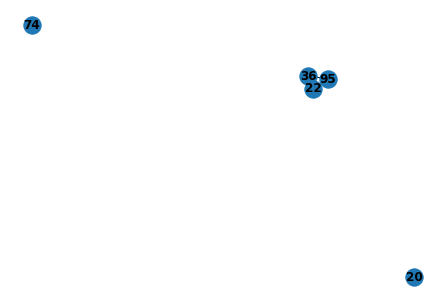

In [264]:
nx.draw(mg, with_labels=True, font_weight='bold')

In [133]:
nx.nx_agraph.write_dot(mg, "test.dot")

In [134]:
B = pgv.AGraph('test.dot')

In [136]:
B.layout() 

In [137]:
B.draw('simple.png')